## Dogs Dataset

dataset link : http://vision.stanford.edu/aditya86/ImageNetDogs/

by [alamsyah hanz](https://github.com/alamhanz)

In [1]:
## reinstall tf and keras
# !conda install keras
# !conda install tensorflow
# !conda install tensorflow-gpu
# !conda install cudnn=7.6.5=cuda10.1_0 --> cuda version is 10.1


In [2]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random

In [3]:
PATH_DATA = '../data/'
PATH_DATA_IMAGES = '../data/Images/'
PATH_DATA_TRAIN = '../data/Images3/train/'
PATH_DATA_VAL = '../data/Images3/val/'
PATH_DATA_TEST = '../data/Images3/test/'
PATH_MODEL = '../../../tmp/'

## Prepare Dataset

In [4]:
mat_train = loadmat(PATH_DATA+'train_list.mat')
mat_test = loadmat(PATH_DATA+'test_list.mat')

In [5]:
data_train_list = [i[0][0] for i in mat_train['file_list']]
data_test_list = [i[0][0] for i in mat_test['file_list']]

label_train_list = [i[0] for i in mat_train['labels']]
label_test_list = [i[0] for i in mat_test['labels']]

In [6]:
## split the train
data_train1_list, data_val_list, label_train1_list, label_val_list = train_test_split(data_train_list, label_train_list, test_size=0.3, random_state=127)

In [7]:
len(data_val_list)

3600

create a training data directory and validation data directory containing one subdirectory per image class.

currently this is the directory of data:

    data/
        Images/
            n02085620-Chihuahua/
                img1_train.jpg
                img2_train.jpg
                ...
                img1_test.jpg
                img2_test.jpg
                ...
            n02085782-Japanese_spaniel/
                img1_train.jpg
                img2_train.jpg
                ...
                img1_test.jpg
                img2_test.jpg
                ...
            ...
                
create new directory as follow:

    data/
        Images2/
            train/
                n02085620-Chihuahua/
                    img1_train.jpg
                    img2_train.jpg
                    ...
                n02085782-Japanese_spaniel/
                    img1_train.jpg
                    img2_train.jpg
                    ...
                ...
                
            val/
                n02085620-Chihuahua/
                    img1_val.jpg
                    img2_val.jpg
                    ...
                n02085782-Japanese_spaniel/
                    img1_val.jpg
                    img2_val.jpg
                ...
                
            test/
                n02085620-Chihuahua/
                    img1_test.jpg
                    img2_test.jpg
                    ...
                n02085782-Japanese_spaniel/
                    img1_test.jpg
                    img2_test.jpg
                ...
                

In [8]:
def new_tree(data_list, TARGET_PATH):
    for img_file in data_list:
        label_folder = img_file.split('/')[0]
        if label_folder not in os.listdir(TARGET_PATH):
            os.mkdir(TARGET_PATH+label_folder)

        src_file = PATH_DATA_IMAGES+img_file
        dest_file = TARGET_PATH+img_file

        shutil.copyfile(src_file, dest_file);
    print('done')

In [9]:
## One time running
new_tree(data_train1_list, PATH_DATA_TRAIN)
new_tree(data_val_list, PATH_DATA_VAL)
new_tree(data_test_list, PATH_DATA_TEST)

done
done
done


In [10]:
len(os.listdir(PATH_DATA_TRAIN)),len(os.listdir(PATH_DATA_TRAIN+'n02085620-Chihuahua'))

(120, 70)

In [11]:
len(os.listdir(PATH_DATA_VAL)),len(os.listdir(PATH_DATA_VAL+'n02085620-Chihuahua'))

(120, 30)

In [12]:
len(os.listdir(PATH_DATA_TEST)),len(os.listdir(PATH_DATA_TEST+'n02085620-Chihuahua'))

(120, 52)

## Simple Exploring

In [13]:
## label dict
label_dict = dict(set([(j,i.split('/')[0].split('-')[1]) for i,j in zip(data_train_list,label_train_list)]))
label_dict

{54: 'Lhasa',
 66: 'clumber',
 99: 'malamute',
 85: 'German_shepherd',
 50: 'Tibetan_terrier',
 30: 'American_Staffordshire_terrier',
 38: 'wire',
 55: 'flat',
 4: 'Pekinese',
 57: 'golden_retriever',
 3: 'Maltese_dog',
 44: 'Dandie_Dinmont',
 13: 'bloodhound',
 78: 'komondor',
 8: 'toy_terrier',
 98: 'Eskimo_dog',
 76: 'briard',
 71: 'Irish_water_spaniel',
 112: 'Pembroke',
 58: 'Labrador_retriever',
 67: 'English_springer',
 108: 'Pomeranian',
 70: 'Sussex_spaniel',
 103: 'pug',
 33: 'Kerry_blue_terrier',
 61: 'vizsla',
 104: 'Leonberg',
 120: 'African_hunting_dog',
 86: 'Doberman',
 21: 'Italian_greyhound',
 27: 'Scottish_deerhound',
 73: 'schipperke',
 37: 'Yorkshire_terrier',
 56: 'curly',
 11: 'basset',
 35: 'Norfolk_terrier',
 117: 'Mexican_hairless',
 20: 'Irish_wolfhound',
 111: 'Brabancon_griffon',
 92: 'boxer',
 65: 'Brittany_spaniel',
 51: 'silky_terrier',
 107: 'Samoyed',
 80: 'Shetland_sheepdog',
 119: 'dhole',
 2: 'Japanese_spaniel',
 15: 'black',
 45: 'Boston_bull',
 11

NOTES : the class is balance on train with 100 images for each class.

In [14]:
pd.Series(label_train1_list).value_counts().describe()

count    120.000000
mean      70.000000
std        4.453306
min       58.000000
25%       67.000000
50%       70.000000
75%       73.000000
max       83.000000
dtype: float64

NOTES: meanwhile the test is dominated by Maltese_dog and Afghan_hound. Meanwhile the Pekinese and Redbone is the least one.

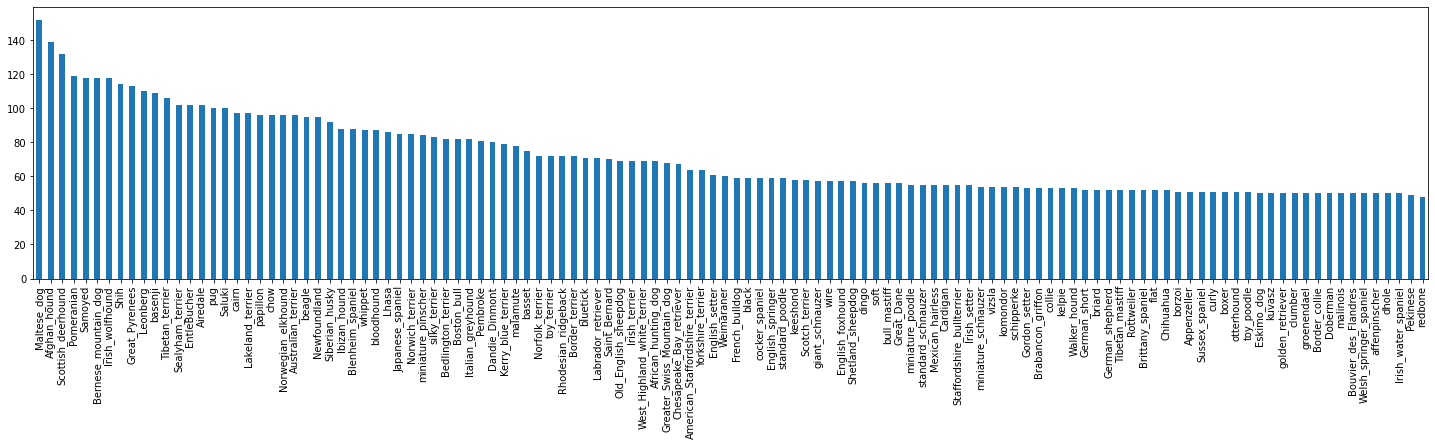

In [15]:
label_test_count = pd.Series(label_test_list).value_counts().sort_values(ascending = False)
ax = label_test_count.reset_index()[0].plot(kind = 'bar', figsize = (25,5))
x_axis_name = [label_dict[i] for i in label_test_count.index]
ax.set_xticklabels(x_axis_name, rotation=90);

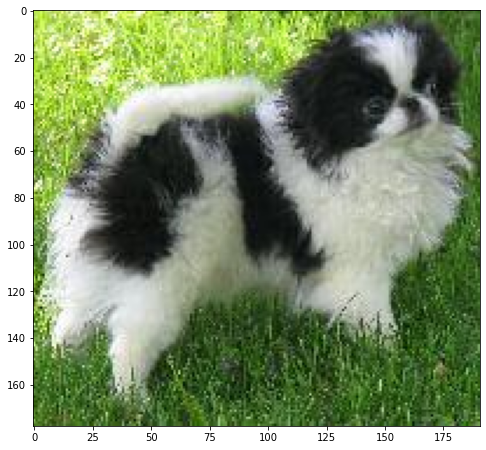

In [16]:
img1 = cv2.imread(PATH_DATA_IMAGES+data_train_list[100])  
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (8,8))
plt.imshow(img1)

In [17]:
img1.shape

(178, 191, 3)

In [18]:
## image sizes in training
train_list1_sample = random.choices(data_train1_list,k = 500)
img_sizes = []
for im in train_list1_sample:
    img1 = cv2.imread(PATH_DATA_IMAGES+im)
    img_sizes.append(img1.shape)
data_sample_sizes = pd.DataFrame(img_sizes, columns = ['h','w','channel'])
data_sample_sizes['file'] = train_list1_sample

In [19]:
data_sample_sizes.channel.unique()

array([3])

<AxesSubplot:>

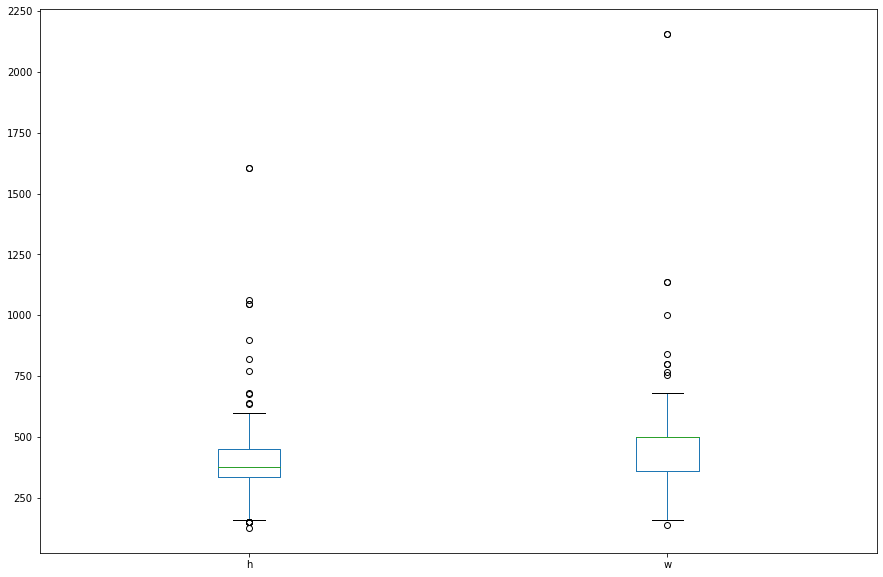

In [20]:
data_sample_sizes[['h','w']].plot(kind = 'box',figsize = (15,10))

In [21]:
data_sample_sizes[['h','w']].describe()

,h,w
count,500.00000,500.000000
mean,388.18600,448.700000
std,135.63494,161.266238
min,125.00000,137.000000
25%,333.00000,360.000000
50%,375.00000,500.000000
75%,450.00000,500.000000
max,1604.00000,2156.000000


NOTES : we will resize the image into (128,128)

## Modeling

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from keras.models import load_model


In [23]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [24]:
LABEL_SIZE = len(label_dict.keys())

In [25]:
dog_img_model = Sequential()
dog_img_model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
dog_img_model.add(Activation('relu'))
dog_img_model.add(MaxPooling2D(pool_size=(2, 2)))

dog_img_model.add(Conv2D(64, (3, 3)))
dog_img_model.add(Activation('relu'))
dog_img_model.add(MaxPooling2D(pool_size=(2, 2)))

dog_img_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
dog_img_model.add(Dense(512))
dog_img_model.add(Dropout(0.5))
dog_img_model.add(Activation('relu'))
dog_img_model.add(Dropout(0.3))
dog_img_model.add(Dense(LABEL_SIZE))
dog_img_model.add(Activation('softmax'))

In [26]:
dog_img_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [27]:
## compile model
opt = keras.optimizers.Adam(learning_rate=0.001)
dog_img_model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.AUC()])

In [28]:
## data generator
BATCH_SIZE = 128
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(128, 128), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(128, 128), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(128, 128),
        batch_size=BATCH_SIZE,
        class_mode="categorical" )

Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 120 classes.


NOTE : "cuDNN failed to initialize" --> try to check the GPU load. Kill some process. (sudo kill -9 < PID >)

In [ ]:
## save best model and use early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',mode='max', patience=8) 
check_p = tf.keras.callbacks.ModelCheckpoint(
        filepath='../../../tmp/dog_model_checkpoint2.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True)

dog_img_model.fit(
        train_generator,
        steps_per_epoch=len(label_train1_list) // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=len(label_val_list) // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=150)

Epoch 1/150
262/262 [==============================] - 72s 273ms/step - loss: 4.8355 - categorical_accuracy: 0.0072 - auc: 0.4994 - val_loss: 4.7897 - val_categorical_accuracy: 0.0053 - val_auc: 0.5000
Epoch 2/150
262/262 [==============================] - 66s 253ms/step - loss: 4.7895 - categorical_accuracy: 0.0075 - auc: 0.4993 - val_loss: 4.7904 - val_categorical_accuracy: 0.0059 - val_auc: 0.5000
Epoch 3/150
141/262 [===============>..............] - ETA: 25s - loss: 4.7865 - categorical_accuracy: 0.0080 - auc: 0.5004

## Evaluations

In [ ]:
model_load = load_model(PATH_MODEL + 'dog_model_checkpoint2.h5')

In [ ]:
true_labels = test_generator.classes
predictions = model_load.predict(test_generator)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

In [ ]:
classification_report(y_true, y_pred)